In [50]:
import pandas as pd

# 데이터 로드

In [51]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print(train.head())

   id  sepal length (cm)  sepal width (cm)  petal length (cm)  \
0   0                4.6               3.6                1.0   
1   1                5.7               4.4                1.5   
2   2                6.7               3.1                4.4   
3   3                4.8               3.4                1.6   
4   4                4.4               3.2                1.3   

   petal width (cm)  species  
0               0.2        0  
1               0.4        0  
2               1.4        1  
3               0.2        0  
4               0.2        0  


# EDA - 데이터 로드 & 기본 확인

In [52]:
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (120, 6)
test shape: (30, 5)


## 컬럼/타입/결측치 확인

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 120 non-null    int64  
 1   sepal length (cm)  120 non-null    float64
 2   sepal width (cm)   120 non-null    float64
 3   petal length (cm)  120 non-null    float64
 4   petal width (cm)   120 non-null    float64
 5   species            120 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 5.8 KB


## 타깃 분포 확인 (species)

In [54]:
train["species"].value_counts().sort_index()

species
0    40
1    41
2    39
Name: count, dtype: int64

## 기초 통계 (feature 분포)

In [55]:
train.describe()

,id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,59.500000,5.809167,3.061667,3.726667,1.183333,0.991667
std,34.785054,0.823805,0.449123,1.752345,0.752289,0.814736
min,0.000000,4.300000,2.000000,1.000000,0.100000,0.000000
25%,29.750000,5.100000,2.800000,1.500000,0.300000,0.000000
50%,59.500000,5.750000,3.000000,4.250000,1.300000,1.000000
75%,89.250000,6.400000,3.400000,5.100000,1.800000,2.000000
max,119.000000,7.700000,4.400000,6.700000,2.500000,2.000000


## 종별(feature) 평균 비교

In [56]:
feature_cols = ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]

train.groupby("species")[feature_cols].mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
species,,,,
0,4.990000,3.452500,1.450000,0.245000
1,5.919512,2.770732,4.241463,1.321951
2,6.533333,2.966667,5.520513,2.000000


## 상관관계 확인

In [57]:
train[feature_cols].corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.106926,0.862175,0.801480
sepal width (cm),-0.106926,1.000000,-0.432089,-0.369509
petal length (cm),0.862175,-0.432089,1.000000,0.962577
petal width (cm),0.801480,-0.369509,0.962577,1.000000


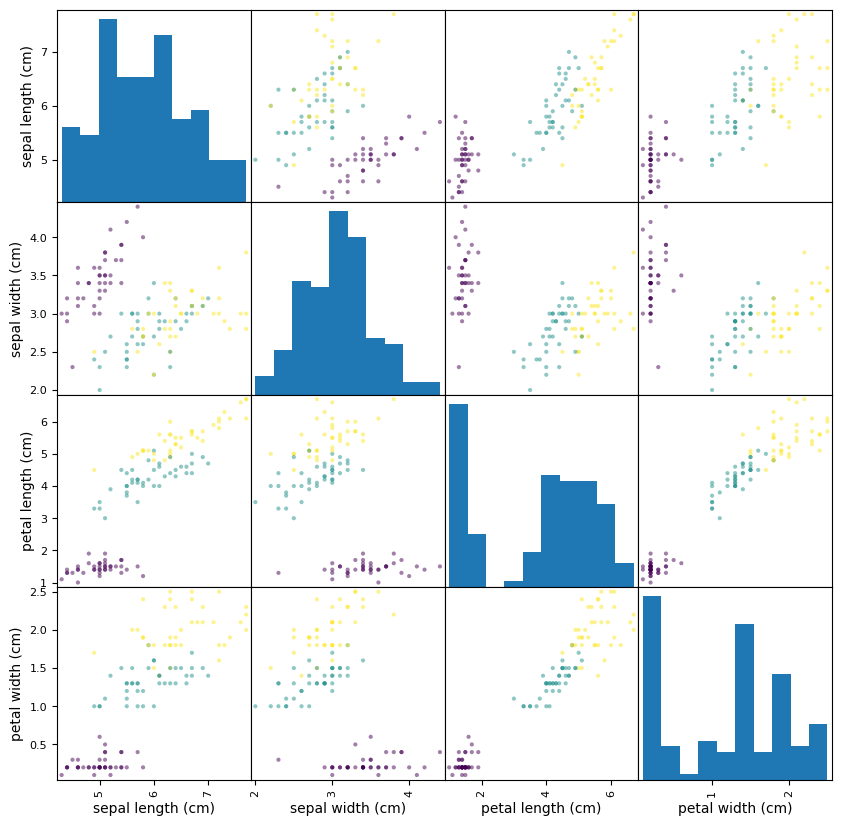

In [58]:
import matplotlib.pyplot as plt
pd.plotting.scatter_matrix(train[feature_cols], 
figsize=(10,10),                                   #그래프 크기
c=train["species"])                                #종별 색깔 자동 지정
plt.show()

# 전처리

In [59]:
feature_cols = ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]
X = train[feature_cols]                #필요없는 id와 결과에 넣을 species 제거 과정
y = train["species"]

# 베이스라인 모델

In [60]:
from sklearn.model_selection import train_test_split

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, 
stratify=y,                              #y 비율이 원래 비율이랑 비슷하게 나눠줌
random_state=42)                         #다른 모델에서 사용할때도 동일한 문제지로 비교하기 위한 시드

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = Pipeline([
    ("scaler", StandardScaler()),                      #표준화 해줘야 선형 회귀에서 영향 안받음 0~1로
    ("clf", LogisticRegression(max_iter=2000))         #이터레이션 기본값이 100인데, 거기서 수렴 안되면 모델 성능에 못미치는 값을 줄 수 있어 늘림
    ])

model.fit(X_tr, y_tr)
pred = model.predict(X_va)
print(accuracy_score(y_va, pred))

1.0


## 교차 검증과 모델 검증

In [62]:
from unittest import result
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogReg": Pipeline([                             #선형 회귀로 선형으로 무리 자르는 모델
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "SVM(RBF)": Pipeline([                           #다른 그룹 개체간 서로 최대거리에 있는 곳에 점을 찍어 잇는 느낌의 모델
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf"))
    ]),
    "KNN": Pipeline([                                #이웃 개수를 보고 많은 쪽으로 변경 그래서 동률이 안나오게 홀수인 5 선택함
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
    "RandomForest": RandomForestClassifier(          #성분에 따라 나뉘는 기준 찾는 방법
        n_estimators=300,                            #트리 개수 제한
        random_state=42                              #값 고정에 의미 있어서 숫자는 의미 없어 시드임
    )
}

results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    results.append({
        "model": name,
        "cv_mean": scores.mean(),                    #평균값 이게 높으면 보통 좋음
        "cv_std": scores.std(),                      #평균값 비슷하면 표준편차 낮은게 전체 모델 안정강 더 좋음
        "fold_scores": np.round(scores, 4)           #특정 분류에서 너무 낮은 그룹은 없는지 보기 위함
    })

pd.DataFrame(results).sort_values("cv_mean", ascending=False)

,model,cv_mean,cv_std,fold_scores
0,LogReg,0.941667,0.042492,"[0.9583, 0.9583, 0.875, 1.0, 0.9167]"
1,SVM(RBF),0.941667,0.042492,"[0.9583, 0.9583, 0.875, 1.0, 0.9167]"
2,KNN,0.941667,0.056519,"[0.9583, 0.9583, 0.8333, 0.9583, 1.0]"
3,RandomForest,0.941667,0.042492,"[0.9583, 0.9583, 0.875, 1.0, 0.9167]"


## 회귀분석 튜닝

In [63]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Cs = [1, 2, 3, 4, 5, 6, 7]
rows = []

for C in Cs:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, C=C))              #규제 강도 조절로 작게하면 과적합 줄이고 크게하면 유연해짐
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    rows.append({"C": C, "mean": scores.mean(), "std": scores.std(), "folds": np.round(scores, 4)})

pd.DataFrame(rows).sort_values("mean", ascending=False)

,C,mean,std,folds
2,3,0.950000,0.031180,"[0.9583, 0.9583, 0.9167, 1.0, 0.9167]"
3,4,0.950000,0.031180,"[0.9583, 0.9583, 0.9167, 1.0, 0.9167]"
4,5,0.950000,0.031180,"[0.9583, 0.9583, 0.9167, 1.0, 0.9167]"
5,6,0.950000,0.031180,"[0.9583, 0.9583, 0.9167, 1.0, 0.9167]"
6,7,0.950000,0.031180,"[0.9583, 0.9583, 0.9167, 1.0, 0.9167]"
0,1,0.941667,0.042492,"[0.9583, 0.9583, 0.875, 1.0, 0.9167]"
1,2,0.941667,0.042492,"[0.9583, 0.9583, 0.875, 1.0, 0.9167]"


# 제출파일

In [64]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, C=3))
])

model.fit(X, y)

test_X = test[feature_cols]
test_pred = model.predict(test_X)

submission = pd.DataFrame({"id": test["id"], "species": test_pred})
submission.to_csv("sample_submission.csv", index=False)

submission.head()

,id,species
0,0,1
1,1,0
2,2,2
3,3,1
4,4,1
